# Setup

### Find paths

In [1]:
repo_path = !git rev-parse --show-toplevel
assert (len(repo_path) == 1)

exec_path = repo_path[0] + "/benchmark_process_packet.exe"
exec_micr_path = repo_path[0] + "/benchmark_process_packet_micr.exe"
exec_path

'/home/bm611/ebsl/benchmark_process_packet.exe'

### Run benchmark function

In [2]:
import numpy as np
import json

tasks = 200_000

def run(scheduler,domains=-1,spawners=-1, path=exec_path):
    cmd = "QUEUE_SIZE=11 " + path  + " -scheduler " + scheduler + " -num-of-domains " + str(domains) + " -num-of-spawners " + str(spawners) + " -items-total " + str(tasks)
    print(cmd)
    output = !$cmd
    return json.loads(''.join(output))

In [3]:
def latency_undo_exp(x):
    return 1.2 ** x 

In [4]:
def find_percentile(array, percentile):
    assert (0 < percentile and percentile < 1)
    
    total = np.sum(array)
    
    percentile_boundary = percentile * total 
    current_total = 0
    for i in range(0,len(array)):
        current_total += array[i]
        if current_total > percentile_boundary:
            return i
    
    return "reached the end before finding percentile boundary"


def transform(parsed):
    time = [] 
    latency_half = []
    latency_threenine = []
    waited_for_space_on_enque = [] 
    latency = []
    latency_q10 = []
    latency_q25 = []
    latency_q50 = []
    latency_q99 = []
    latency_q999 = [] 
    latency_q9999 = []
    latency_q99999 = []

    for row in parsed['data']:
        if row['iteration'] == 1:
            continue

        time.append(row['time'])
        latency_half.append(latency_undo_exp(row['latency_median']))
        latency_threenine.append(latency_undo_exp(row['latency_three_nine']))
        waited_for_space_on_enque.append(row['waited-for-space-on-enque'])
        latency.append(row['latency'])
        
        latency_q50.append(latency_undo_exp(find_percentile(row['latency'], 0.5)))
        latency_q99.append(latency_undo_exp(find_percentile(row['latency'], 0.99)))
        latency_q999.append(latency_undo_exp(find_percentile(row['latency'], 0.999)))
        latency_q9999.append(latency_undo_exp(find_percentile(row['latency'], 0.9999)))
        latency_q99999.append(latency_undo_exp(find_percentile(row['latency'], 0.99999)))
                

    return {'time':time, 
            'waited_for_space_on_enque':waited_for_space_on_enque,
            'latency':latency,
            'latency_q50':latency_q50,
            'latency_q99':latency_q99,
            'latency_q999':latency_q999,
            'latency_q9999':latency_q9999,
            'latency_q99999':latency_q99999,
            'latency_half':latency_half,
            'median_latency_threenine':latency_threenine,
           }

In [5]:
def to_median_and_errs(array):
    median = np.median(array)
    lower_err = median - np.quantile(array, 0.25)
    upper_err = np.quantile(array, 0.75) - median
    return {'median': median, 'lower_err': lower_err, 'upper_err': upper_err}
    
def add_metrics(data):
    data['time-processed'] = to_median_and_errs(data['time'])
    data['latency_half-processed'] = to_median_and_errs(data['latency_half'])
    data['latency_threenine-processed'] = to_median_and_errs(data['median_latency_threenine'])
    data['waited_for_space_on_enque-processed'] = to_median_and_errs(data['waited_for_space_on_enque'])
    
    data['throughput-processed'] = to_median_and_errs((tasks * 1_000.)/np.array(data['time']))
    
    data['latency_q50-processed'] = to_median_and_errs(data['latency_q50'])
    data['latency_q99-processed'] = to_median_and_errs(data['latency_q99'])
    data['latency_q999-processed'] = to_median_and_errs(data['latency_q999'])
    data['latency_q9999-processed'] = to_median_and_errs(data['latency_q9999'])
    data['latency_q99999-processed'] = to_median_and_errs(data['latency_q99999'])
    
    

### Plotting

In [20]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
import matplotlib
matplotlib.rc('font', **font)

# Experiment 1: simple workload, skewed

## Data collection

In [7]:
param_space = range(115, 120, 5)
x = list(param_space)

In [133]:
param_space = range(115, 120, 5)

fifo = []
for i in param_space:
    fifo.append(run("FIFO", domains=i, spawners=min(int(i/2)+1, 5)))

lifo = []
for i in param_space:
    lifo.append(run("LIFO", domains=i, spawners=min(int(i/2)+1, 5)))
    

hybrid_random = []
for i in param_space:
    hybrid_random.append(run("hybrid_random", domains=i, spawners=min(int(i/2)+1, 5)))

hybrid_alternating = []
for i in param_space:
    hybrid_alternating.append(run("hybrid_alternating", domains=i, spawners=min(int(i/2)+1, 5)))
    
    
hybrid_reverse_every_n = []
for i in param_space:
    hybrid_reverse_every_n.append(run("hybrid_reverse_every_n", domains=i, spawners=min(int(i/2)+1, 5)))
    
x = list(param_space)

QUEUE_SIZE=11 /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO -num-of-domains 115 -num-of-spawners 5 -items-total 200000
QUEUE_SIZE=11 /home/bm611/ebsl/benchmark_process_packet.exe -scheduler LIFO -num-of-domains 115 -num-of-spawners 5 -items-total 200000
QUEUE_SIZE=11 /home/bm611/ebsl/benchmark_process_packet.exe -scheduler hybrid_random -num-of-domains 115 -num-of-spawners 5 -items-total 200000
QUEUE_SIZE=11 /home/bm611/ebsl/benchmark_process_packet.exe -scheduler hybrid_alternating -num-of-domains 115 -num-of-spawners 5 -items-total 200000
QUEUE_SIZE=11 /home/bm611/ebsl/benchmark_process_packet.exe -scheduler hybrid_reverse_every_n -num-of-domains 115 -num-of-spawners 5 -items-total 200000


In [205]:

hybrid_random = []
for i in param_space:
    hybrid_random.append(run("hybrid_random", domains=i, spawners=min(int(i/2)+1, 5)))
    
    

fifo_with_slot = []
for i in param_space:
    fifo_with_slot.append(run("FIFO_with_slot", domains=i, spawners=min(int(i/2)+1, 5)))
    
    

QUEUE_SIZE=11 /home/bm611/ebsl/benchmark_process_packet.exe -scheduler hybrid_random -num-of-domains 115 -num-of-spawners 5 -items-total 200000
QUEUE_SIZE=11 /home/bm611/ebsl/benchmark_process_packet.exe -scheduler FIFO_with_slot -num-of-domains 115 -num-of-spawners 5 -items-total 200000


In [206]:
run_name = "base"

In [208]:
import pickle


#with open('packet_fifo_' + run_name + '.pickle', 'wb') as handle:
#    pickle.dump(fifo, handle)
    
fifo = pickle.load(open('packet_fifo_' + run_name + '.pickle', 'rb'))

#with open('packet_lifo_' + run_name + '.pickle', 'wb') as handle:
#    pickle.dump(lifo, handle)
    
lifo = pickle.load(open('packet_lifo_' + run_name + '.pickle', 'rb'))

#with open('packet_hybrid_random_' + run_name + '.pickle', 'wb') as handle:
#    pickle.dump(hybrid_random, handle)

#hybrid_random = pickle.load(open('packet_hybrid_random_' + run_name + '.pickle', 'rb'))

#with open('packet_hybrid_alternating_' + run_name + '.pickle', 'wb') as handle:
#    pickle.dump(hybrid_alternating, handle)
    
hybrid_alternating = pickle.load(open('packet_hybrid_alternating_' + run_name + '.pickle', 'rb'))

#with open('packet_hybrid_reverse_every_n_' + run_name + '.pickle', 'wb') as handle:
#    pickle.dump(hybrid_reverse_every_n, handle)
hybrid_reverse_every_n = pickle.load(open('packet_hybrid_reverse_every_n_' + run_name + '.pickle', 'rb'))


#with open('packet_fifo_with_slot' + run_name + '.pickle', 'wb') as handle:
#    pickle.dump(fifo_with_slot, handle)
fifo_with_slot = pickle.load(open('packet_fifo_with_slot' + run_name + '.pickle', 'rb'))

In [210]:
fifo_transformed = []
for row in fifo:
    fifo_transformed.append(transform(row))
    
lifo_transformed = []
for row in lifo:
    lifo_transformed.append(transform(row))
    

hybrid_random_transformed = []
for row in hybrid_random:
    hybrid_random_transformed.append(transform(row))
    
hybrid_alternating_transformed = []
for row in hybrid_alternating:
    hybrid_alternating_transformed.append(transform(row))
    
hybrid_reverse_every_n_transformed = []
for row in hybrid_reverse_every_n:
    hybrid_reverse_every_n_transformed.append(transform(row))
    
    
fifo_with_slot_transformed = []
for row in fifo_with_slot:
    fifo_with_slot_transformed.append(transform(row))

In [212]:
for row in fifo_transformed:
    add_metrics(row)
for row in lifo_transformed:
    add_metrics(row)

for row in hybrid_random_transformed:
    add_metrics(row)

for row in hybrid_alternating_transformed:
    add_metrics(row)
    
for row in hybrid_reverse_every_n_transformed:
    add_metrics(row)


    
for row in fifo_with_slot_transformed:
    add_metrics(row)

In [163]:
micr = []
for i in param_space:
    micr.append(run("LIFO", domains=17, spawners=5, path=exec_micr_path))

QUEUE_SIZE=11 /home/bm611/ebsl/benchmark_process_packet_micr.exe -scheduler LIFO -num-of-domains 17 -num-of-spawners 5 -items-total 200000


In [164]:
#with open('packet_micr_' + run_name + '.pickle', 'wb') as handle:
#    pickle.dump(micr, handle)
 
micr = pickle.load(open('packet_micr_' + run_name + '.pickle', 'rb'))

    
micr_transformed = []
for row in micr:
    micr_transformed.append(transform(row))
    
for row in micr_transformed:
    add_metrics(row)


## Analysis

### Exec time vs number of domains

In [165]:
def to_series(data, label):
    return [v[label]["median"] for v in data]

In [166]:
def plot(x, data, key, name):
    y = [v[key]["median"] for v in data]
    lower_errbar = [v[key]["lower_err"] for v in data]
    upper_errbar = [v[key]["upper_err"] for v in data]
    
    return ax.errorbar(x, y, [lower_errbar, upper_errbar], label=name)
    

In [167]:
'''size = 1

fig, axes = plt.subplots(size, 1)
fig.set_size_inches(12, 4 * size)
#fig.tight_layout()
'''
'''
ax = axes[0]

#line_lifo, = ax.plot(x, to_series(fifo_transformed, "time-processed"), label='FIFO')
#line_fifo, = ax.plot(x, to_series(lifo_transformed, "time-processed"), label='LIFO')

line_lifo = plot(x, fifo_transformed, "throughput-processed", 'FIFO')
line_fifo = plot(x, lifo_transformed, "throughput-processed", 'LIFO')

ax.legend(handles=[line_fifo, line_lifo])

#ax.set_yscale("log")
ax.set_ylim(ymin=0)
ax.set_xlabel('domains count')
ax.set_title("Throughput of packet benchmark with cache dependency.") 
ax.set_ylabel('throughput (task/s)')

########################
## TIME ################
########################

ax = axes[1]
#line_lifo, = ax.plot(x, to_series(fifo_transformed, "time-processed"), label='FIFO')
#line_fifo, = ax.plot(x, to_series(lifo_transformed, "time-processed"), label='LIFO')

line_lifo = plot(x, fifo_transformed, "time-processed", 'FIFO')
line_fifo = plot(x, lifo_transformed, "time-processed", 'LIFO')

ax.set_ylim(ymin=1)
#ax.set_title("Time to complete the benchmark.") 
ax.set_ylabel('execution time (ms)')


########################
## MEDIAN LATENCY ######
########################

ax = axes[2]


line_lifo = plot(x, fifo_transformed, "latency_q50-processed", 'FIFO')
line_fifo = plot(x, lifo_transformed, "latency_q50-processed", 'LIFO')


#ax.set_yscale("log")
ax.set_ylim(ymin=1)
ax.set_ylabel('latency (μs)')
ax.set_title("Median latency.") 

########################
## Q99 LATENCY ######
########################
'''
'''
ax = axes


line_lifo = plot(x, fifo_transformed, "latency_q999-processed", 'FIFO')
line_fifo = plot(x, lifo_transformed, "latency_q999-processed", 'LIFO')
ax.legend(handles=[line_fifo, line_lifo])

ax.set_yscale("log")
#ax.set_ylim(ymin=0, ymax=50_0000)
ax.set_ylabel('latency (μs)')
ax.set_title("99.9% percentile latency of packet process benchmark with varying task chains.") 


########################
## Q99.9 LATENCY ######
########################
'''
'''
ax = axes[4]


line_lifo = plot(x, fifo_transformed, "latency_q9999-processed", 'FIFO')
line_fifo = plot(x, lifo_transformed, "latency_q9999-processed", 'LIFO')

ax.set_yscale("log")
#ax.set_ylim(ymin=0, ymax=50_0000)
ax.set_ylabel('latency (μs)')
ax.set_title("99.99% percentile latency.") 

########################
## WAIT ################
########################

ax = axes[5]


line_lifo = plot(x, fifo_transformed, "waited_for_space_on_enque-processed", 'FIFO')
line_fifo = plot(x, lifo_transformed, "waited_for_space_on_enque-processed", 'LIFO')

ax.set_yscale("log")
ax.set_ylim(ymin=1)
ax.set_xlabel('domains count')
ax.set_ylabel('busy-wait loops (count)')
ax.set_title("Number of retries on task insertion due to lack of space") 
'''

'''
ax.set_xlabel('domains count')
plt.tight_layout()
plt.autoscale()
plt.savefig("packet-basic-" + run_name + ".png", dpi=200)'''

None

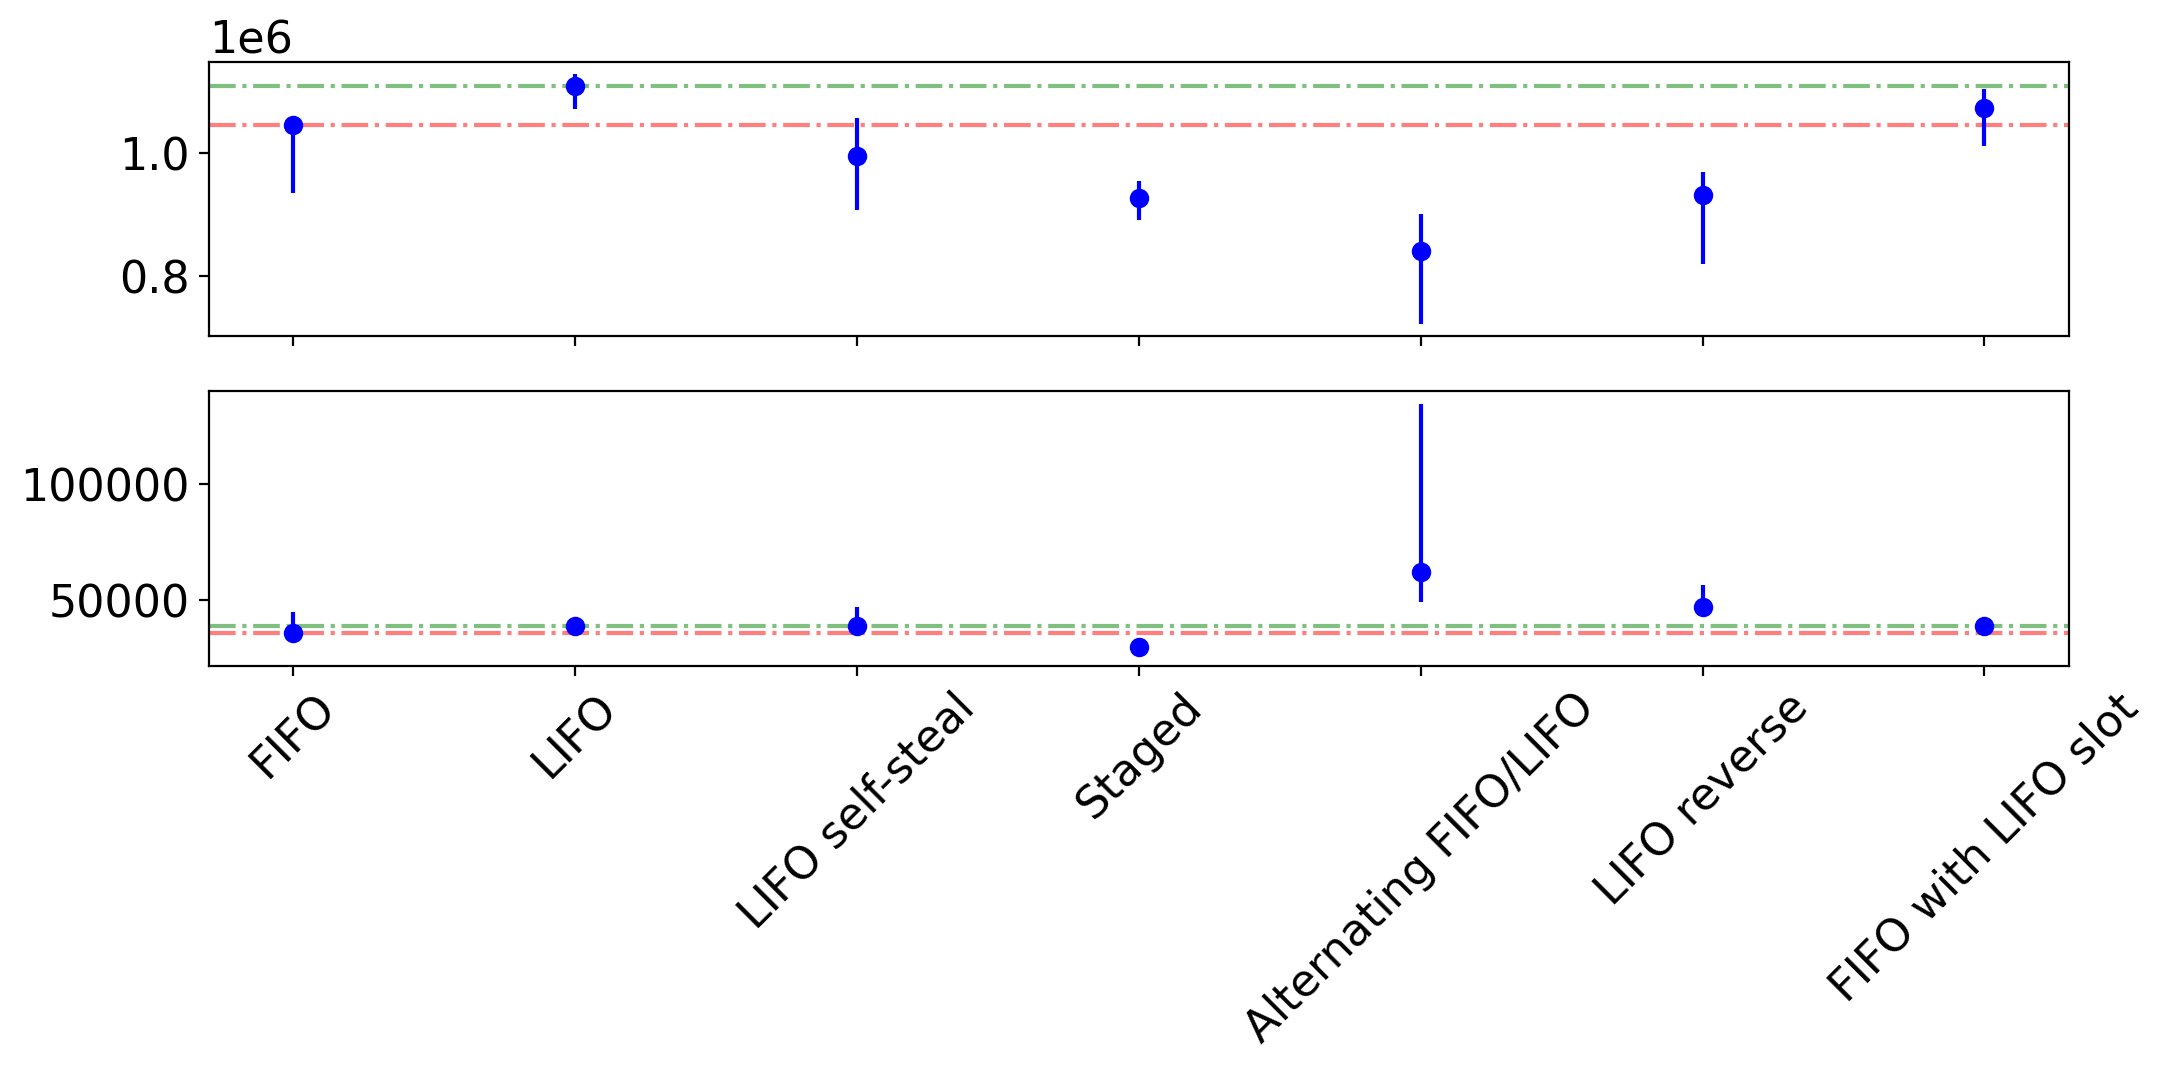

In [244]:
def to_bar_plot(key, data, name):
    y = [v[key]["median"] for v in data]
    lower_errbar = [v[key]["lower_err"] for v in data]
    upper_errbar = [v[key]["upper_err"] for v in data]
    
    return ([name], y, lower_errbar, upper_errbar)

def transpose(v):
    (a,b,c,d) = v
    return (sum(a, []),sum(b, []),sum(c, []),sum(d, []))




collected = [("FIFO", fifo_transformed),
     ("LIFO", lifo_transformed),
     ("LIFO self-steal", hybrid_random_transformed), 
     ("Staged", micr_transformed),
     ("Alternating FIFO/LIFO", hybrid_alternating_transformed), 
     ("LIFO reverse", hybrid_reverse_every_n_transformed),
     ("FIFO with LIFO slot", fifo_with_slot_transformed)
            ]

import matplotlib.pyplot as plt
size = 1
fig, axes = plt.subplots(2, 1, sharex=True)
fig.set_size_inches(12, 4 * size)

ax = axes[0]


ax.axhline(y=fifo_transformed[0]["throughput-processed"]["median"], color='r', linestyle='-.', alpha=0.5)
ax.axhline(y=lifo_transformed[0]["throughput-processed"]["median"], color='g', linestyle='-.', alpha=0.5)

bar_plot_data = map(lambda v: to_bar_plot("throughput-processed", v[1], v[0]), collected)
(x, y, lower_errbar, upper_errbar) = transpose(tuple(zip(*bar_plot_data)))
ax.errorbar(x, y, 
            (lower_errbar, upper_errbar), fmt="o", color="b")





ax = axes[1]

ax.axhline(y=fifo_transformed[0]["latency_q99-processed"]["median"], color='r', linestyle='-.', alpha=0.5)
ax.axhline(y=lifo_transformed[0]["latency_q99-processed"]["median"], color='g', linestyle='-.', alpha=0.5)

bar_plot_data = map(lambda v: to_bar_plot("latency_q99-processed", v[1], v[0]), collected)
(x, y_2, lower_errbar, upper_errbar) = transpose(tuple(zip(*bar_plot_data)))
ax.errorbar(x, y_2, 
            (lower_errbar, upper_errbar), fmt="o", color="b")


plt.xticks(rotation=45)
plt.show()

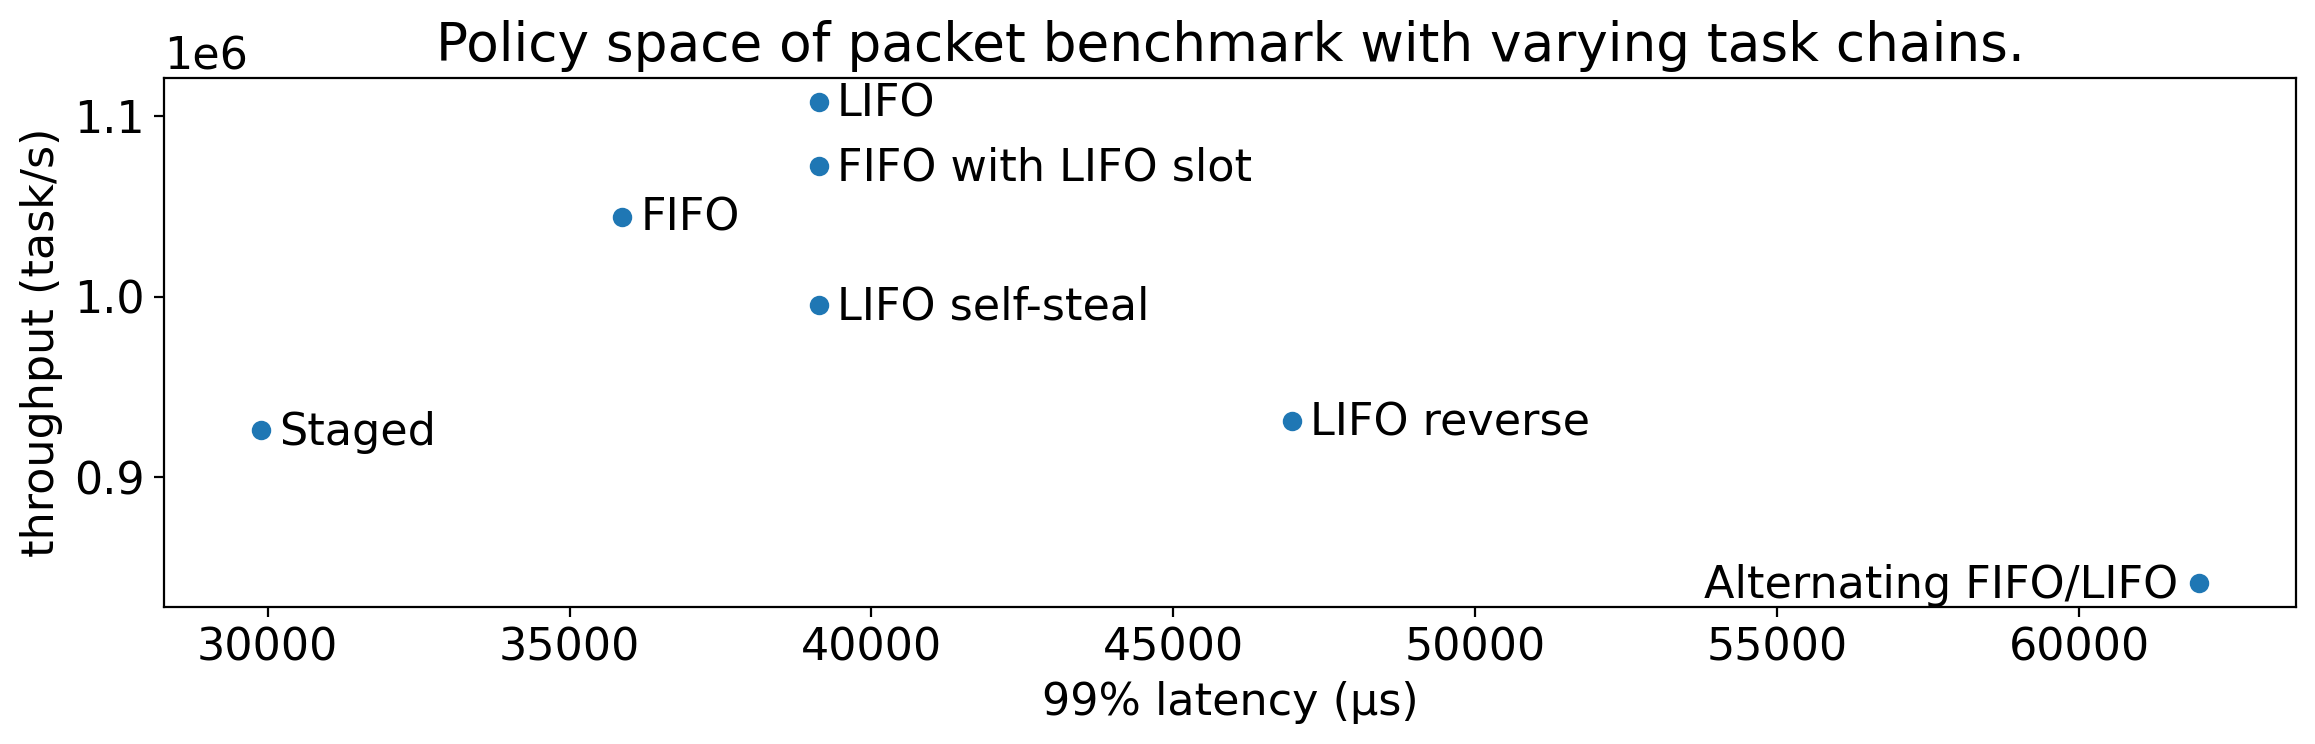

In [260]:

fig, axes = plt.subplots(1, 1, sharex=True)
fig.set_size_inches(12, 4 * size)

ax = axes


ax.scatter(y_2, y)


for i, txt in enumerate(x):
    x_shift = 0
    if 'Alternating' in txt:
        x_shift = -8500
    ax.annotate(txt, (y_2[i] + x_shift + 300, y[i]-8500))


#ax.set_yscale("log")
ax.set_xlabel('99% latency (μs)')
ax.set_ylabel('throughput (task/s)')
ax.set_title("Policy space of packet benchmark with varying task chains.") 
    

plt.tight_layout()
plt.autoscale()
plt.savefig("packet-basic-" + run_name + ".png", dpi=200)
